In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from keras.layers import LSTM, Dense, Embedding, Dropout
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.regularizers import L1L2
from keras.optimizers import Adam
from keras.utils import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV,learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

In [2]:
ConcatedReel = pd.read_csv('ConcatenatedReel_preprocessed.csv');
ConcatedFake = pd.read_csv('ConcatenatedFake_preprocessed.csv');

# Create a new column with the label for each dataset
ConcatedReel['label'] = 1
ConcatedFake['label'] = 0

# Concatenate the datasets and shuffle the rows
data = pd.concat([ConcatedReel, ConcatedFake], ignore_index=True)
data = data.sample(frac=1, random_state=42)

# Drop the rows with NaN values and length less than 5
data = data.dropna()
data = data[data['text_token_lemmatized'].apply(lambda x: len(x) >= 5)]

# Split the data into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42, stratify=data['label'])

In [3]:
import xgboost as xgb
# Create a pipeline with TF-IDF vectorization and XGBoost classifier
pipeline_xgb = make_pipeline(TfidfVectorizer(), xgb.XGBClassifier())

# Define a grid of hyperparameters to search over
param_grid_xgb = {
    'tfidfvectorizer__max_features': [10000, 20000, 30000],
    'xgbclassifier__n_estimators': [100, 200, 300],
    'xgbclassifier__max_depth': [10, 20, 30]
}

# Perform a randomized search to find the best hyperparameters for XGBoost
grid_xgb = RandomizedSearchCV(pipeline_xgb, param_grid_xgb, cv=5, n_iter=50, random_state=42)
grid_xgb.fit(X_train, y_train)

# Print the best hyperparameters and the test accuracy
print("Best hyperparameters for XGBoost: ", grid_xgb.best_params_)
test_accuracy_xgb = grid_xgb.score(X_test, y_test)
print("Test accuracy for XGBoost: ", test_accuracy_xgb)

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best hyperparameters for XGBoost:  {'xgbclassifier__n_estimators': 300, 'xgbclassifier__max_depth': 30, 'tfidfvectorizer__max_features': 20000}
Test accuracy for XGBoost:  0.8967018248786205


In [4]:
best_xgb = grid_xgb.best_estimator_
joblib.dump(best_xgb, 'XGBoost.joblib')

['XGBoost.joblib']

Best hyperparameters for logistic regression:  {'tfidfvectorizer__max_features': 20000, 'logisticregression__penalty': 'l2', 'logisticregression__C': 10.0}
Test accuracy for logistic regression:  0.9107651096601372


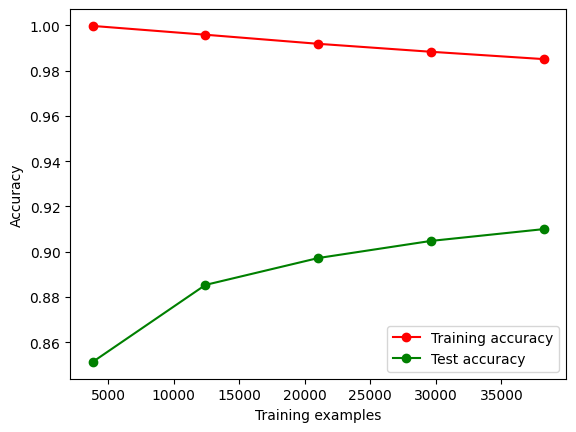

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

# Create a pipeline with TF-IDF vectorization and logistic regression
pipeline_lr = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=500, solver='liblinear'))

# Define a grid of hyperparameters to search over
param_grid_lr = {
    'tfidfvectorizer__max_features': [10000, 20000, 30000],
    'logisticregression__C': [0.1, 1.0, 10.0],
    'logisticregression__penalty': ['l1', 'l2']
}

# Perform a randomized search to find the best hyperparameters for logistic regression
grid_lr = RandomizedSearchCV(pipeline_lr, param_grid_lr, cv=5, n_iter=10, random_state=42)
grid_lr.fit(X_train, y_train)

# Print the best hyperparameters and the test accuracy
print("Best hyperparameters for logistic regression: ", grid_lr.best_params_)
test_accuracy_lr = grid_lr.score(X_test, y_test)
print("Test accuracy for logistic regression: ", test_accuracy_lr)

# Plot the learning curve for train loss and accuracy
train_sizes, train_scores, test_scores = learning_curve(grid_lr.best_estimator_, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training accuracy")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test accuracy")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()


In [ ]:
# Create a pipeline with TF-IDF vectorization and random forest classifier
pipeline_rf = make_pipeline(TfidfVectorizer(), RandomForestClassifier())

# Define a grid of hyperparameters to search over
param_grid_rf = {
    'tfidfvectorizer__max_features': [10000, 20000, 30000],
    'randomforestclassifier__n_estimators': [100, 200, 300],
    'randomforestclassifier__max_depth': [10, 20, 30]
}

# Perform a randomized search to find the best hyperparameters for random forest
grid_rf = RandomizedSearchCV(pipeline_rf, param_grid_rf, cv=5, n_iter=50, random_state=42)
grid_rf.fit(X_train, y_train)

# Print the best hyperparameters and the test accuracy
print("Best hyperparameters for random forest: ", grid_rf.best_params_)
test_accuracy_rf = grid_rf.score(X_test, y_test)
print("Test accuracy for random forest: ", test_accuracy_rf)

In [2]:


# Save the best logistic regression model
lr_model = grid_lr.best_estimator_
joblib.dump(lr_model, 'LogisticModel.joblib')

# Save the best random forest model
rf_model = grid_rf.best_estimator_
joblib.dump(rf_model, 'RandomForest.joblib')


NameError: name 'grid_lr' is not defined

In [1]:
import joblib
# Load the best logistic regression model
best_lr_model = joblib.load('LogisticModel.joblib')
# Load the best random forest model
best_rf_model = joblib.load('RandomForest.joblib')

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.2.1 when

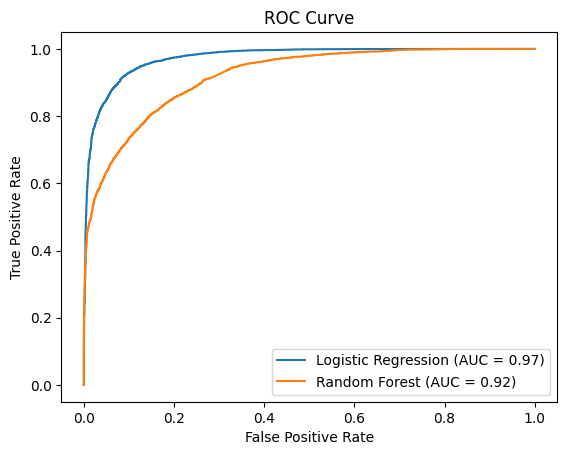

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities of the positive class for the test set
y_pred_prob_lr = best_lr_model.predict_proba(X_test)[:, 1]
y_pred_prob_rf = best_rf_model.predict_proba(X_test)[:, 1]

# Compute the false positive rate, true positive rate, and AUC for the Logistic Regression model
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_prob_lr)
auc_lr = auc(fpr_lr, tpr_lr)

# Compute the false positive rate, true positive rate, and AUC for the Random Forest model
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_prob_rf)
auc_rf = auc(fpr_rf, tpr_rf)
# Plot the ROC curve for the Logistic Regression model
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = %0.2f)' % auc_lr)
# Plot the ROC curve for the Random Forest model
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = %0.2f)' % auc_rf)
# Set the title and labels for the plot
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Add a legend to the plot
plt.legend()
# Show the plot
plt.show()

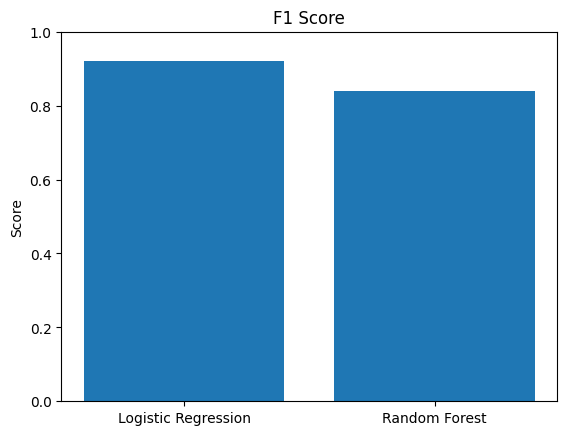

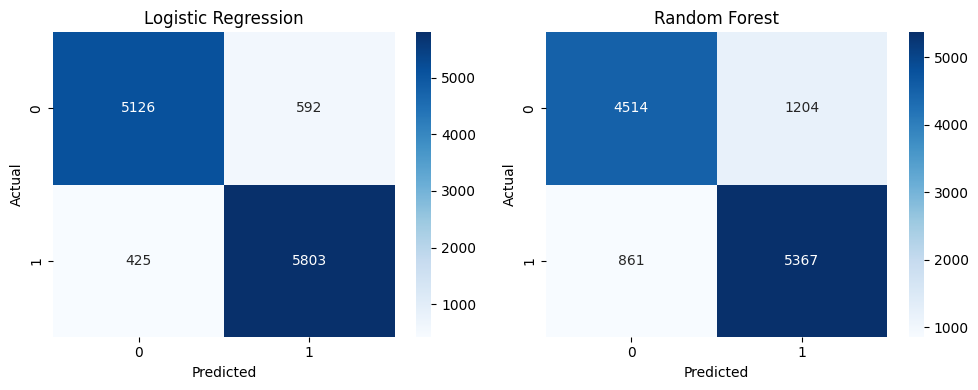

In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

# Get the predicted labels for the test set
y_pred_lr = best_lr_model.predict(X_test)
y_pred_rf = best_rf_model.predict(X_test)

# Compute the F1 score for the Logistic Regression model
f1_lr = f1_score(y_test, y_pred_lr)

# Compute the F1 score for the Random Forest model
f1_rf = f1_score(y_test, y_pred_rf)

# Plot the F1 scores for both models
plt.bar(['Logistic Regression', 'Random Forest'], [f1_lr, f1_rf])
plt.title('F1 Score')
plt.ylabel('Score')
plt.ylim([0, 1])
plt.show()

# Compute the confusion matrix for the Logistic Regression model
cm_lr = confusion_matrix(y_test, y_pred_lr)

# Compute the confusion matrix for the Random Forest model
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrices for both models
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0])
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[0].set_title('Logistic Regression')
axes[1].set_title('Random Forest')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
plt.tight_layout()
plt.show()

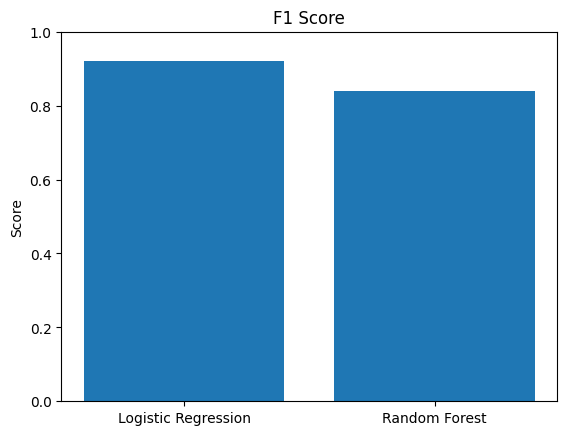

In [11]:

# Get the predicted labels for the test set
y_pred_lr = best_lr_model.predict(X_test)
y_pred_rf = best_rf_model.predict(X_test)

# Compute the F1 score for the Logistic Regression model
f1_lr = f1_score(y_test, y_pred_lr)

# Compute the F1 score for the Random Forest model
f1_rf = f1_score(y_test, y_pred_rf)

# Create a list of F1 scores for both models
f1_scores = [f1_lr, f1_rf]

# Set the names of the models
model_names = ['Logistic Regression', 'Random Forest']

# Set the positions of the bars on the x-axis
x_pos = np.arange(len(model_names))

# Create the bar chart
plt.bar(x_pos, f1_scores)

# Set the names of the models as the x-tick labels
plt.xticks(x_pos, model_names)

# Set the title and y-label of the plot
plt.title('F1 Score')
plt.ylabel('Score')

# Set the y-axis limits
plt.ylim([0, 1])

# Show the plot
plt.show()

In [8]:
import graphviz
from sklearn.tree import export_graphviz
from sklearn.inspection import partial_dependence

# Load the saved Random Forest model
rf_model = joblib.load('RandomForest.joblib')

# Extract the RandomForestClassifier object from the pipeline
rf_classifier = rf_model.named_steps['randomforestclassifier']

# Get the feature names from the TfidfVectorizer object
vectorizer = rf_model.named_steps['tfidfvectorizer']
feature_names = [feature for feature, idx in sorted(vectorizer.vocabulary_.items(), key=lambda x: x[1])]

# Create a decision tree visualization for the first tree in the forest
tree = rf_classifier.estimators_[0]
dot_data = export_graphviz(tree, out_file=None, feature_names=feature_names, filled=True)
graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render('tree', view=True)

# Create a partial dependence plot for the first feature
fig, axs = partial_dependence(rf_classifier, X_train, [0], feature_names=feature_names)
plt.suptitle('Partial Dependence Plot')
plt.subplots_adjust(top=0.9)
plt.show()

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.2.1 

IndexError: tuple index out of range

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Load the best logistic regression model
best_lr_model = joblib.load('LogisticModel.joblib')

# Extract the LogisticRegression object from the pipeline
lr_model = best_lr_model.named_steps['logisticregression']

# Get the regularization parameter values that were used to fit the model
c_values = 1.0 / lr_model.Cs_

# Compute the training loss values for each value of C
loss_values = []
for i, c_value in enumerate(lr_model.Cs_):
    lr_model.C = c_value
    lr_model.coef_ = best_lr_model.named_steps['logisticregression'].coef_[i].reshape(1, -1)
    loss_values.append(lr_model.loss(lr_model.coef_, lr_model.predict_proba(lr_model.X), lr_model.y, 0))

# Plot the training loss function
plt.plot(c_values, loss_values)
plt.title('Training Loss Function')
plt.xlabel('Regularization Strength (C)')
plt.ylabel('Loss')
plt.xscale('log')
plt.show()

AttributeError: 'LogisticRegression' object has no attribute 'Cs_'

In [2]:


import pandas as pd
testfalse = pd.read_csv('zaytungtest.csv')
testtrue = pd.read_csv('teyittest.csv')
testtrue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  101 non-null    int64 
 1   datetime    101 non-null    object
 2   tweet_Id    101 non-null    int64 
 3   text        101 non-null    object
 4   Username    101 non-null    object
dtypes: int64(2), object(3)
memory usage: 4.1+ KB


In [13]:
import numpy as np
zaytung_predict = best_lr_model.predict(testfalse["text"])
teyit_test = best_rf_model.predict(testtrue["text"])

zaytung_count_0 = np.count_nonzero(zaytung_predict == 0) # zaytung_predict dizisindeki 0'ların sayısı
zaytung_count_1 = np.count_nonzero(zaytung_predict == 1) # zaytung_predict dizisindeki 1'lerin sayısı

teyit_test_0 = np.count_nonzero(teyit_test == 0) # zaytung_predict dizisindeki 0'ların sayısı
teyit_test_1 = np.count_nonzero(teyit_test == 1) # zaytung_predict dizisindeki 1'lerin sayısı

print("zaytung test oranı: " + str(1 - (zaytung_count_1 / zaytung_count_0)))
print("teyit org test oranı: " + str(1 - (teyit_test_0 / teyit_test_1)))

zaytung test oranı: 0.9479166666666666
teyit org test oranı: 1.0
